In [245]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import analysis_utils as utils
import importlib
import h5py

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [402]:
c = 299792458    # m / s
SI2ev = (1 / 1.6e-19) * c

m = 2000 * (83.5e-9)**3 * 4 * np.pi / 3
hbar = 6.626e-34
kb = 1.380649e-23

## Derive new calibration factor

In [65]:
folder = r'/Users/yuhan/work/nanospheres/data/20241007_force_calibration'
dataset = r''
combined_path = os.path.join(folder, dataset, '20241007_*_89khz_*.hdf5')
data_files = glob.glob(combined_path)

In [66]:
vp2p = [0.5, 1, 1.5, 2]
order = [0, 2, 3, 1]
data_files_ordered_89khz = [data_files[i] for i in order]

c_mv_89khz = utils.get_c_mv(data_files_ordered_89khz, vp2p, 89000 * 2 * np.pi, passband=(88700, 89300), charge=10, n_chunk=5)
means_89khz = np.mean(np.asarray(c_mv_89khz), axis=1)
errors_89khz = np.sqrt(np.var(np.asarray(c_mv_89khz), axis=1) / (5-1))

The averaged calibration factor $C_{mV}$ = 4.872e-08


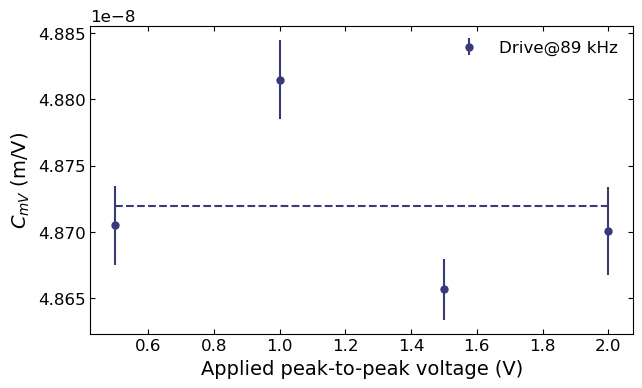

In [67]:
colors = plt.colormaps.get_cmap('tab20b').resampled(6).colors
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.errorbar(vp2p, means_89khz, yerr=errors_89khz, fmt='.', markersize=10, label='Drive@89 kHz')
ax.hlines(np.mean(means_89khz), vp2p[0], vp2p[-1], linestyle='--', color=colors[0])

ax.set_xlabel('Applied peak-to-peak voltage (V)')
ax.set_ylabel('$C_{mV}$ (m/V)')

# ax.set_ylim(9.3e-8, 1e-7)
ax.legend(frameon=False)

c_mv = np.mean(means_89khz)
print(fr'The averaged calibration factor $C_{{mV}}$ = {c_mv:.3e}')

In [89]:
file = r'/Users/yuhan/work/nanospheres/data/20241007_force_calibration/20241007_noefield_4e-8mbar.hdf5'
dtt, nn = utils.load_timestreams(file, ['D'])
fs = int(np.ceil(1/dtt))

zz = nn[0]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

Text(50, 5e-29, 'Imprecision noise floor: 2.01e-27 m$^2$/Hz')

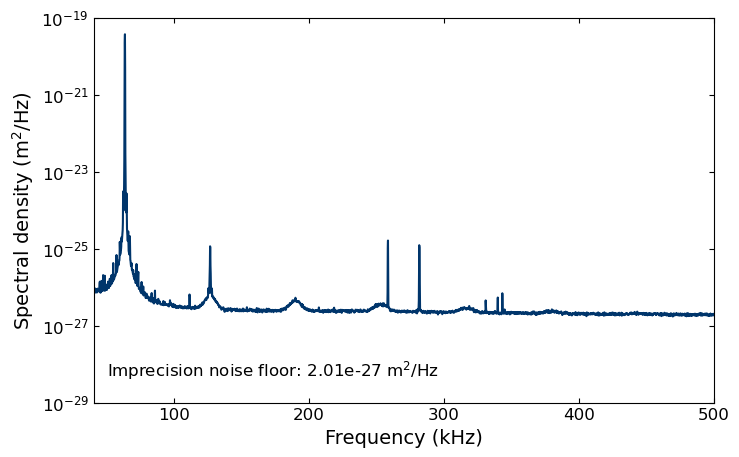

In [233]:
ccal = 1 / (c_mv**2)
ffz, ppz = utils.get_psd(dt=dtt, zz=zz, nperseg=2**14)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(ffz/1000, ppz/ccal, '-',color=yale_colors[0])
# ax.plot(ffz/1000, np.exp(utils.log_lorentzian_with_const(ffz*2*np.pi, *popt)), 'k', label='Fit')

ax.set_yscale('log')
ax.set_ylim(1e-29, 1e-19)
ax.set_xlim(40, 500)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Spectral density (m$^2$/Hz)')

all_idx = np.logical_and(ffz>400000, ffz<450000)
noise_floor = np.mean(ppz[all_idx]/ccal)
ax.text(50, 0.5e-28, f'Imprecision noise floor: {noise_floor:.2e} m$^2$/Hz', fontsize=12)
# ax.text(50, 1.75e-28, f'$\eta_{{z}}$ $\simeq$ {2.13e-27 / noise_floor:.2f} (?)', fontsize=12)

## Calibration waveform measured right out of chamber

In [307]:
def get_pulse_area(data_files):
    tt, dd, aa = [], [], []
    for file in data_files:
        data = np.genfromtxt(file, delimiter=',', skip_header=2).T
        tt.append(data[0])  # time in us
        dd.append(data[1])  # V

        noise = np.mean(data[1]>0.8)
        area = np.trapz(data[1]-noise, data[0]*1e-6)
        aa.append(np.abs(area))

    tt = np.asarray(tt)
    dd = np.asarray(dd)
    aa = np.asarray(aa)
    
    return tt, dd, aa

In [308]:
folder = r'/Users/yuhan/work/nanospheres/data/pulse_waveform'

tts, dds, aas = [], [], []
for dataset in ['1v', '3v', '5v', '7v', '9v']:
    combined_path = os.path.join(folder, dataset, '*/*.csv')
    data_files = sorted(glob.glob(combined_path))
    tt, dd, aa = get_pulse_area(data_files)
    
    tts.append(tt)
    dds.append(dd)
    aas.append(aa)

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_30380/2692186935.py:14: SyntaxWarning: invalid escape sequence '\D'
  axes[i].set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV/c', fontsize=10)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_30380/2692186935.py:14: SyntaxWarning: invalid escape sequence '\p'
  axes[i].set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV/c', fontsize=10)


<bound method Figure.tight_layout of <Figure size 1200x300 with 5 Axes>>

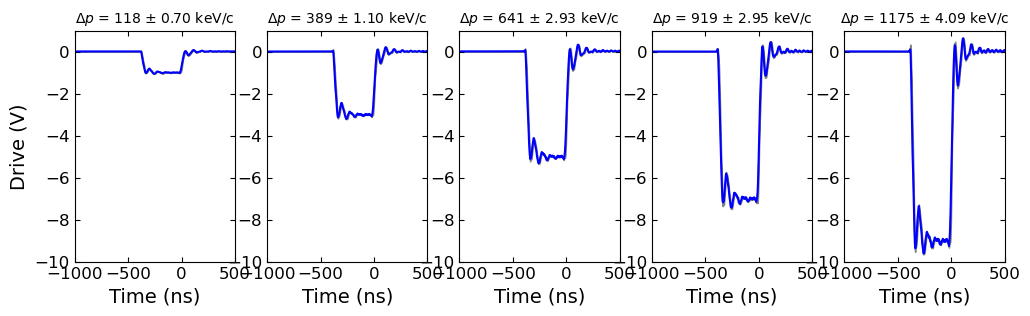

In [326]:
charge = 10
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    
    mean = np.mean(dds[i], axis=0)
    std = np.std(dds[i], axis=0)
    
    amp_kev = charge * np.mean(aas[i]) * 120 * 1.602e-19 * SI2ev / 1000
    amp_kev_std = charge * np.std(aas[i]) * 120 * 1.602e-19 * SI2ev / 1000
    
    axes[i].fill_between(tts[i][0]*1000, mean-std, mean+std, color='grey', alpha=0.95)
    axes[i].plot(tts[i][0]*1000, mean, color='blue')
    
    axes[i].set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV/c', fontsize=10)

    axes[i].set_xlim(-1000, 500)
    axes[i].set_ylim(-10, 1)
    
    if i == 0:
        axes[i].set_ylabel('Drive (V)')

    axes[i].set_xlabel('Time (ns)')

fig.tight_layout

## Short pulse calibration

In [509]:
folder = r'/Users/yuhan/work/nanospheres/data/20241007_10e_data'
datasets = ['20241007_1v_4e-8mbar', '20241007_3v_4e-8mbar', '20241007_5v_4e-8mbar', '20241007_7v_4e-8mbar', '20241007_9v_4e-8mbar']
pulseamps = [118, 389, 641, 919, 1175]

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

Calibrate the unnormalized amplitudes to physical units. Fit a Guassian and find the best fit center

In [328]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
# Take the average of 700 and 900 kev cases
amp2kev = np.mean(np.asarray(amp2kevs[-2:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]

(0.0, 2000.0)

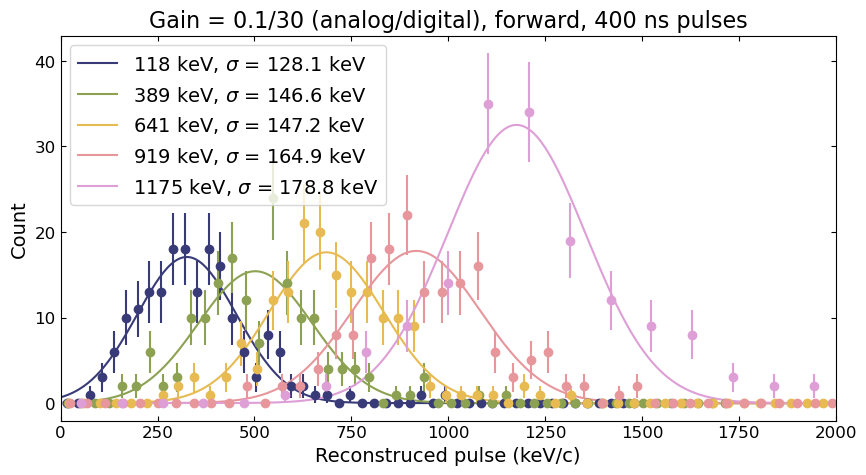

In [335]:
fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 400 ns pulses')
ax.set_xlim(0, 2000)

Also fit the noise data. Fitting doesn't work very well (to be improved in the future), but from the distribution it looks consistent with above (sigma ~ 150 keV), and slightly worse for the 1175 keV case.

In [512]:
unnormalized_amps_noise = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, True)

20241007_1v_4e-8mbar
20241007_3v_4e-8mbar
20241007_5v_4e-8mbar
20241007_7v_4e-8mbar
20241007_9v_4e-8mbar


In [551]:
importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:406: SyntaxWarning: invalid escape sequence '\s'
  gps_normalized = [gps[i][0], gps[i][1]*amp2kev, gps[i][2]*amp2kev]
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:408: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:413: SyntaxWarning: invalid escape sequence '\s'
  ax.errorbar(bcs[i], hhs[i], yerr=np.sqrt(hhs[i]), fmt='o', color=color)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:415: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=color)


<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

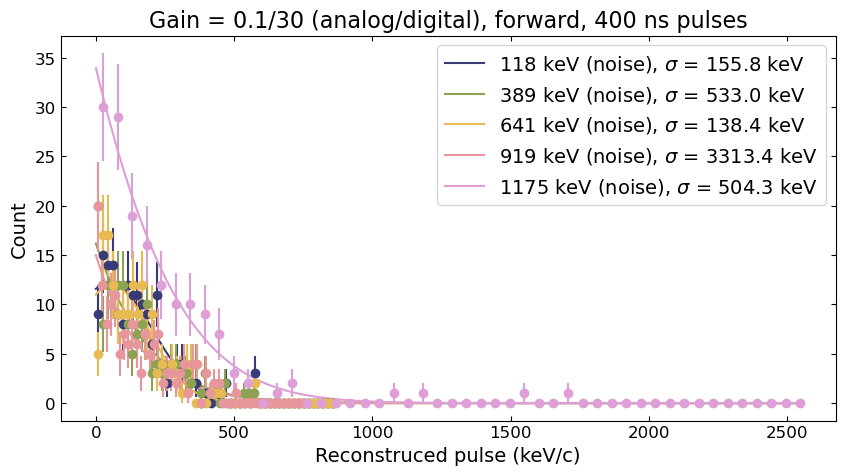

In [552]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus(unnormalized_amps_noise, True)
normalized_amps_noise = [amp * amp2kev for amp in unnormalized_amps_noise]

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps_noise, hhs_noise, bcs_noise, gps_noise, amp2kev=amp2kev, noise=True, title='Gain = 0.1/30 (analog/digital), forward, 400 ns pulses')


Take sigma to be the fitted resolution of 300, 500, and 700 keV cases

In [330]:
sigma_det = np.mean(np.asarray([gps[i][2] for i in [2, 3]]) * amp2kev)

In [331]:
def get_detection_efficiency(normalized_amps, sigma, threshold=3):
    eff = []
    for amps in normalized_amps:
        eff.append(np.count_nonzero(amps > threshold * sigma) / amps.size)
    return eff

from scipy.special import erf
from scipy.optimize import curve_fit

def func(x, a, b, z, f):
    return a * erf((x - z) * f) + b

In [344]:
detection_efficiency = get_detection_efficiency(normalized_amps, sigma_det, 5)
popt, pcov = curve_fit(func, pulseamps, detection_efficiency, p0=[1, 0, 0, 0.005], maxfev=5000)

[0.01098901098901099, 0.06060606060606061, 0.30538922155688625, 0.8373493975903614, 0.9695121951219512]
[4.78431484e-01 4.99617557e-01 7.33946505e+02 3.94893396e-03]


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_30380/3772172693.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.text(45, 0.75, f'$\sigma_p$ = {sigma_det:.2f} keV/c', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_30380/3772172693.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('5-$\sigma_p$ signal efficiency')


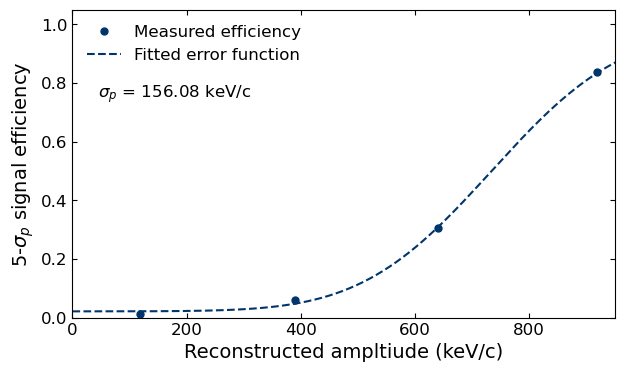

In [346]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

f = interp1d(pulseamps, detection_efficiency, 'linear')

xx = np.linspace(0, pulseamps[-1], 200)
ax.plot(pulseamps, detection_efficiency, '.', markersize=10, label='Measured efficiency',color=yale_colors[0])
ax.plot(xx, func(xx, *popt), '--',label='Fitted error function', color=yale_colors[0])
ax.text(45, 0.75, f'$\sigma_p$ = {sigma_det:.2f} keV/c', fontsize=12)

ax.legend(frameon=False)
ax.set_xlim(0, 950)
ax.set_ylim(0, 1.05)
ax.set_xlabel('Reconstructed ampltiude (keV/c)')
ax.set_ylabel('5-$\sigma_p$ signal efficiency')

print(detection_efficiency)
print(popt)

## Look into the reconstructed waveforms

In [339]:
folder = r'/Users/yuhan/work/nanospheres/data/20241007_10e_data'
dataset = r'20241007_9v_4e-8mbar'
combined_path = os.path.join(folder, dataset, '*.hdf5')
data_files = sorted(glob.glob(combined_path))

In [340]:
data_files

['/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_0.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_1.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_2.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_3.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_4.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_5.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_6.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_7.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_8.hdf5',
 '/Users/yuhan/work/nanospheres/data/20241007_

In [465]:
def recon_pulses(file):
    dtt, nn = utils.load_timestreams(file, ['D', 'G'])
    tt = np.arange(0, dtt*(nn[0].size), dtt)
    fs = int(np.ceil(1 / dtt))

    zz, dd = nn[0], nn[1]
    zz_bp = utils.bandpass_filtered(zz, fs, 40000, 100000)
    pulse_idx = utils.get_pulse_idx(dd, -0.5, False)

    windows, fs, f_lps, amps, temp = [], [], [], [], []
    for i, idx in enumerate(pulse_idx):
        if idx < 100000 or idx > zz.size-100000:
            continue
        window, f, f_lp, amp = utils.recon_pulse(idx, dtt, zz_bp, dd, False, None, 40000, 40000, 50, 30)
        
        # Estimate the sphere temperature
        ffz, ppz = utils.get_psd(dt=dtt, zz=zz[window], nperseg=2**15)  
        in_band = np.logical_and(ffz>40000, ffz<100000)
        omega0 = ffz[in_band][np.argmax(ppz[in_band])] * 2 * np.pi
        
        windows.append(window)
        fs.append(f)
        f_lps.append(f_lp)
        amps.append(amp)
        
        temp.append(m * omega0**2 * np.trapz(ppz, ffz) * c_mv**2 / kb)
        
    return dtt, dd, windows, fs, f_lps, pulse_idx, temp, amps

In [464]:
amp2kev = 4881.810673408754

def plot_recon(dtt, dd, windows, fs, f_lps, pulse_idx, temp):
    fig, axes = plt.subplots(6, 3, figsize=(12, 12))
    
    offset_plot = 100
    search_window_length = 50
    pulse_length = 30

    for i, ax in enumerate(axes.flatten()):
        if i > len(windows) or i == len(windows):
            continue
        window = windows[i]
        amp = fs[i]
        amp_lp = f_lps[i]
        idx = pulse_idx[i]
        
        amp_plot = amp2kev * amp[offset_plot:-1*offset_plot]/1e9
        amp_lp_plot = amp2kev * amp_lp[offset_plot:-1*offset_plot]/1e9
        dd_plot = dd[window][offset_plot:-1*offset_plot]
        tt_plot = dtt * np.arange(0, amp_plot.size)*1e6

        ax.plot(tt_plot-39000*dtt*1e6, amp_plot, alpha=0.5, linewidth=0.5)
        ax.plot(tt_plot-39000*dtt*1e6, amp_lp_plot)

        ax.twinx().plot(tt_plot-39000*dtt*1e6, dd_plot, color='lightgrey', alpha=0.7)

        pulse_idx_in_window = np.argmin(dd[window])
        search_window = utils.get_search_window(amp_lp, pulse_idx_in_window, search_window_length, pulse_length)

        idx_amp_in_search_window = np.argmax(np.abs(amp_lp[search_window])/1e9)
        idx_amp_plot = idx_amp_in_search_window + pulse_idx_in_window + pulse_length

        ax.plot((idx_amp_plot- offset_plot- 39000)*dtt*1e6, amp2kev*amp_lp[idx_amp_plot]/1e9, color='k', marker='o', fillstyle='none', markersize=8)

        ax.set_ylim(-2000, 2000)
        ax.set_xlim(0*dtt*1e6, 2000*dtt*1e6)
    #     ax.twinx().set_ylim(-10, 0.5)
        ax.set_title(f'Temperature = {temp[i]:.1f} K')

        if i % 3 == 0:
            ax.set_ylabel('Amp. (keV/c)')
        if i==15 or i==16:
            ax.set_xlabel('Time ($\mu$s)')

    fig.tight_layout()
    plt.plot()

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_30380/3733956622.py:44: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')


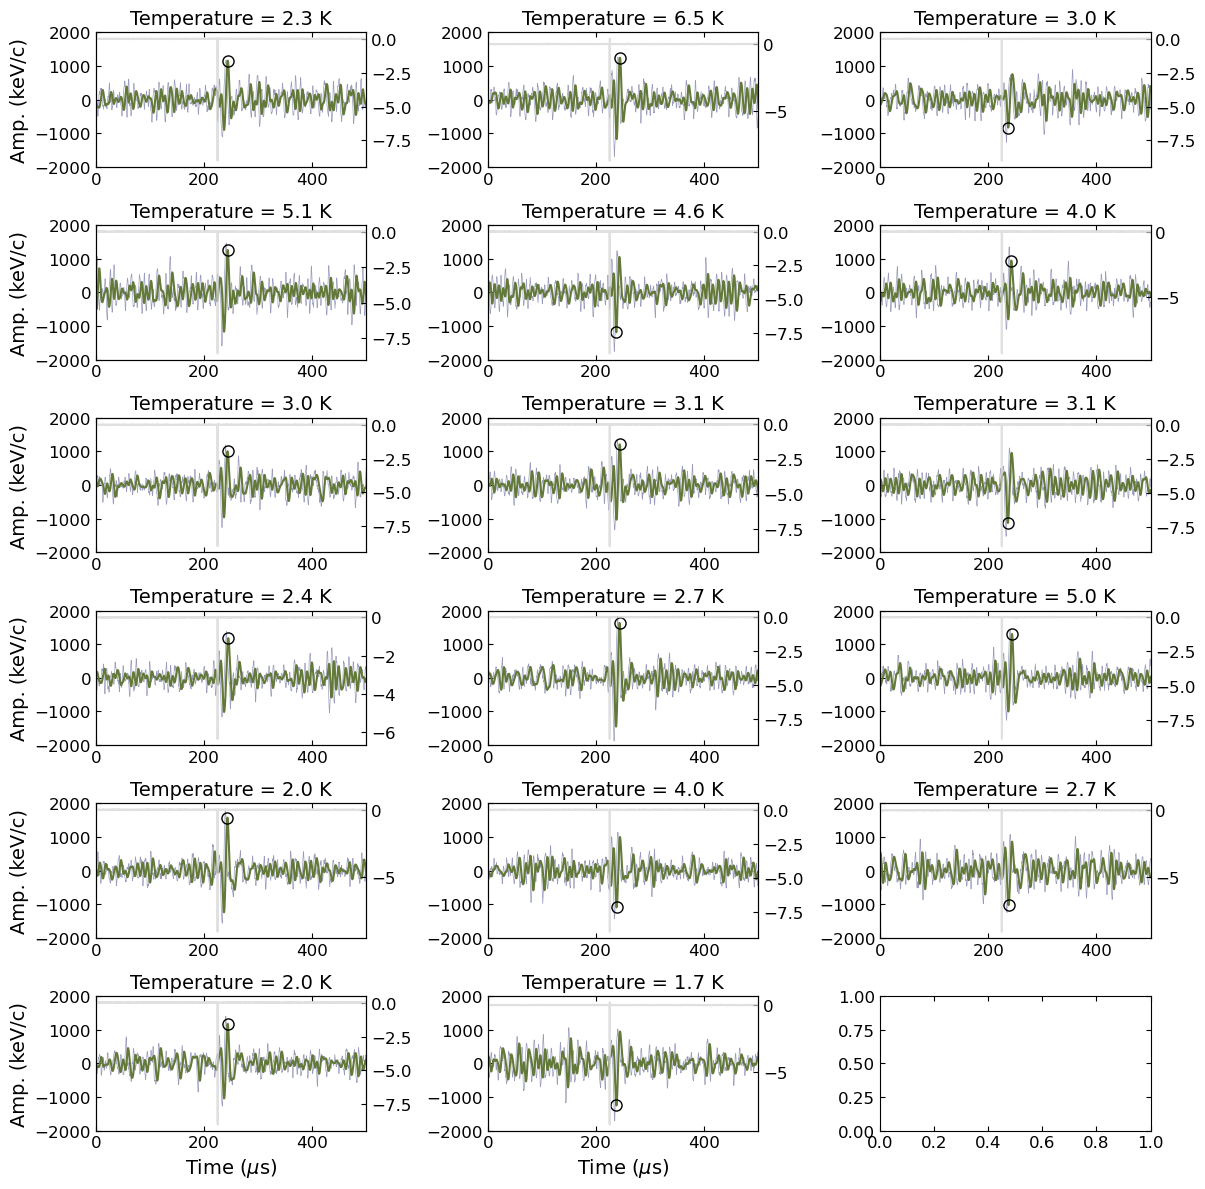

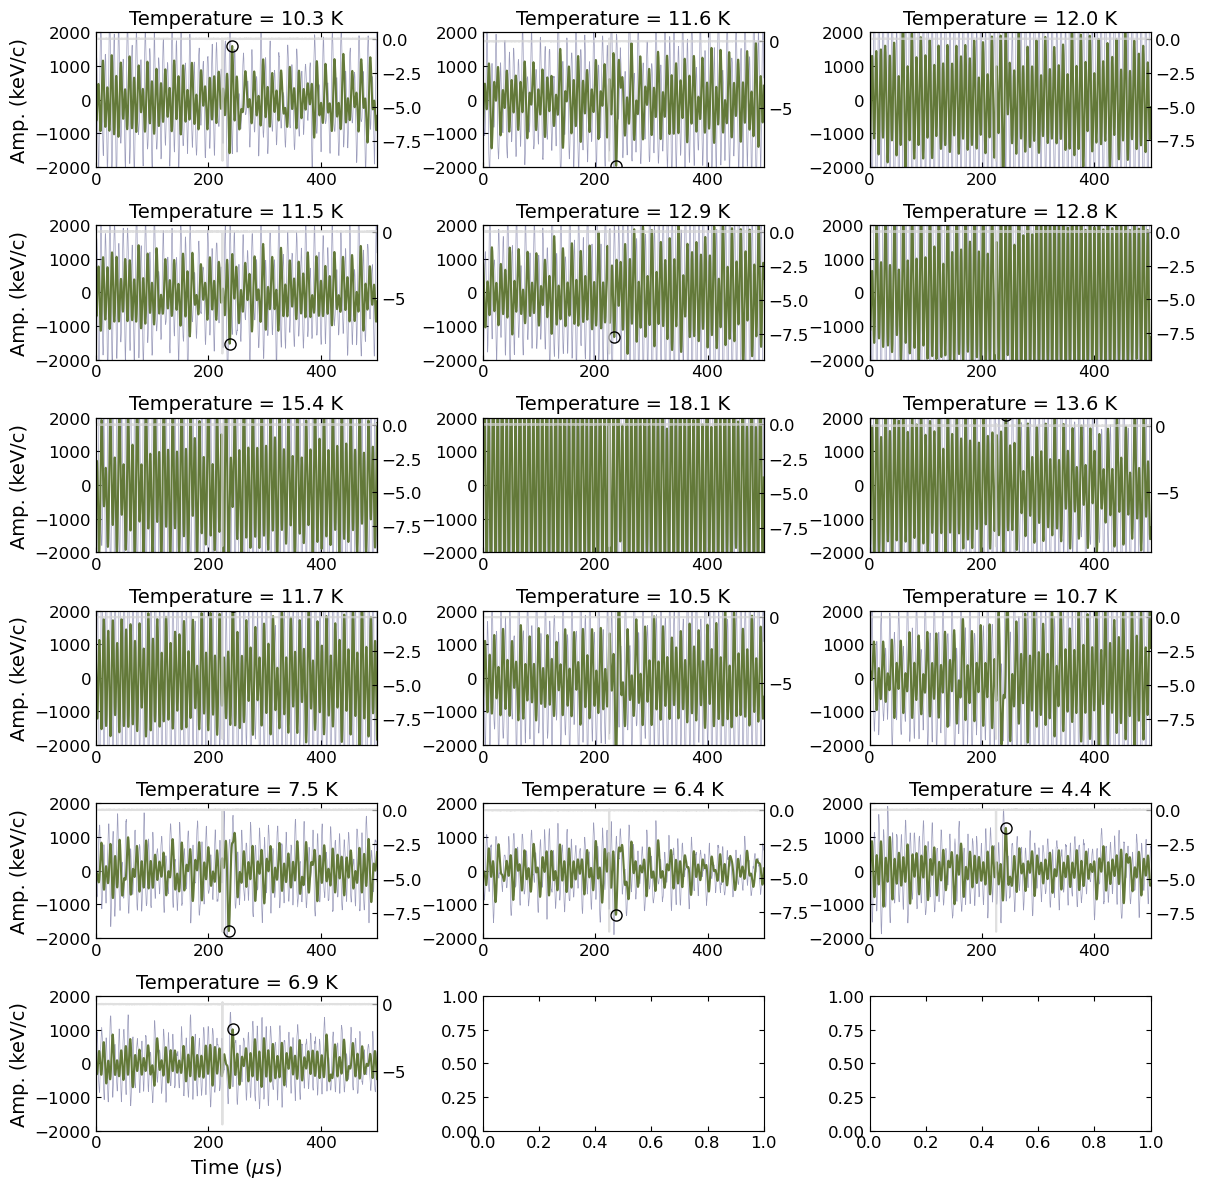

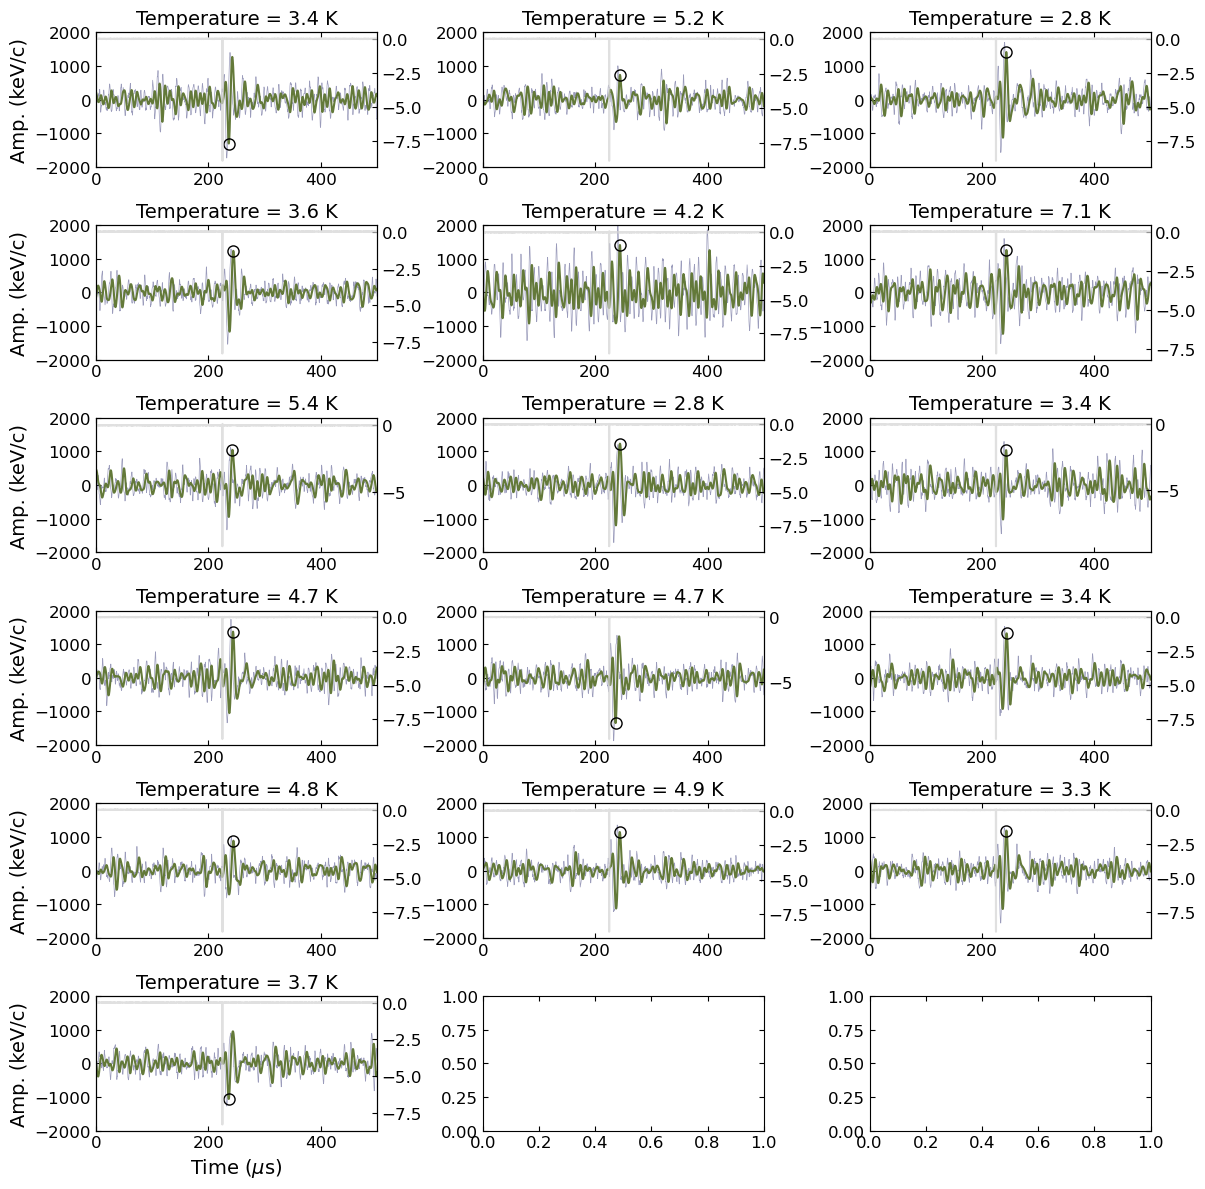

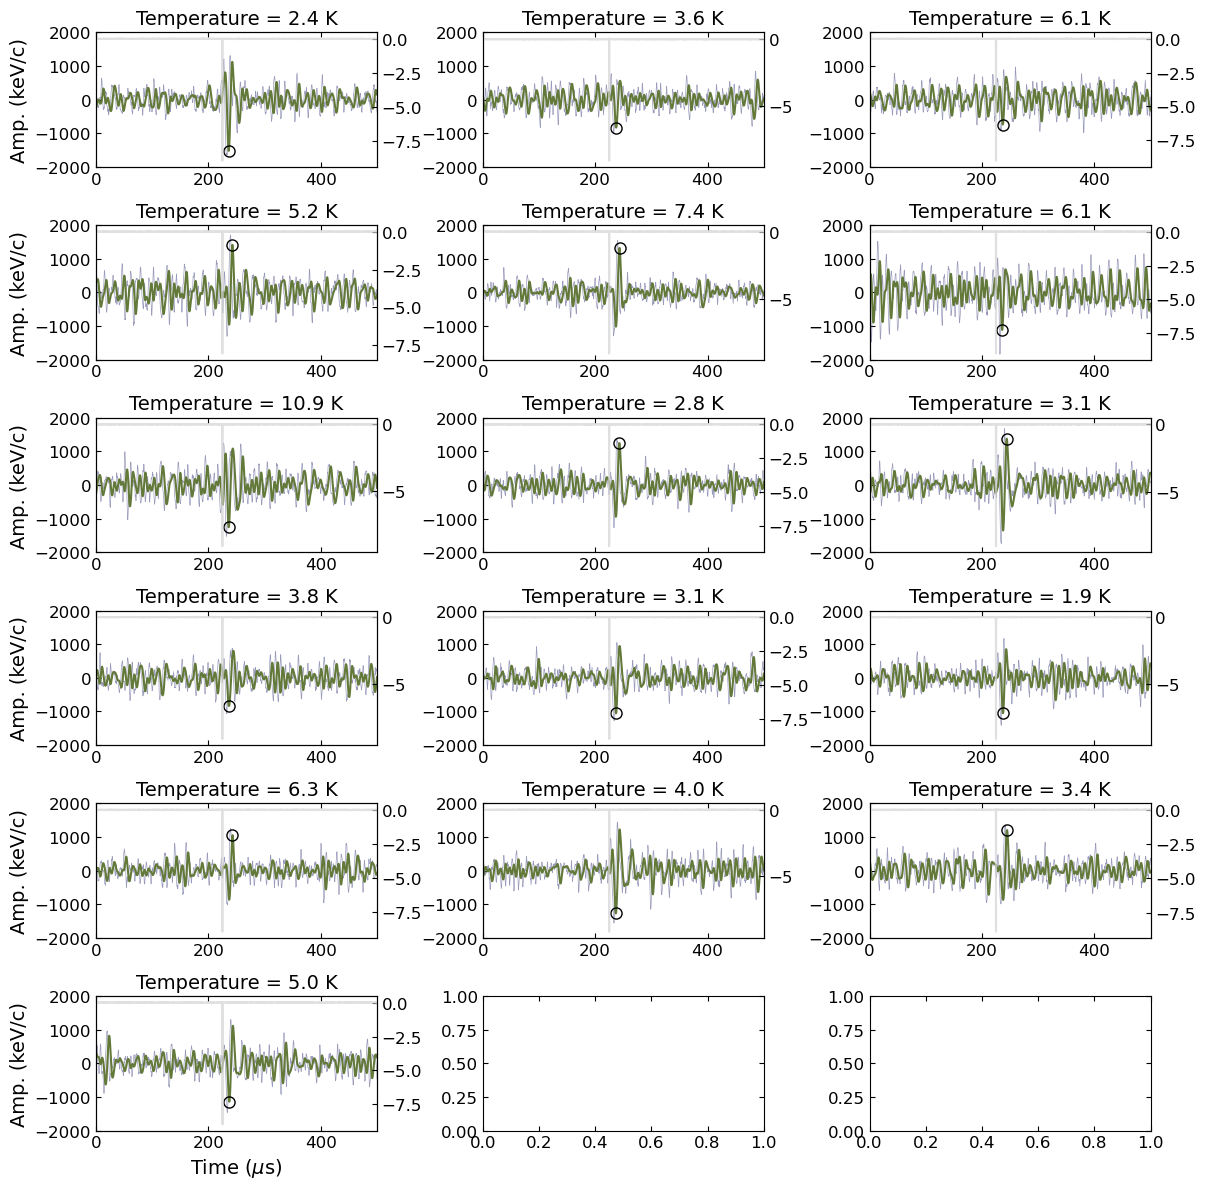

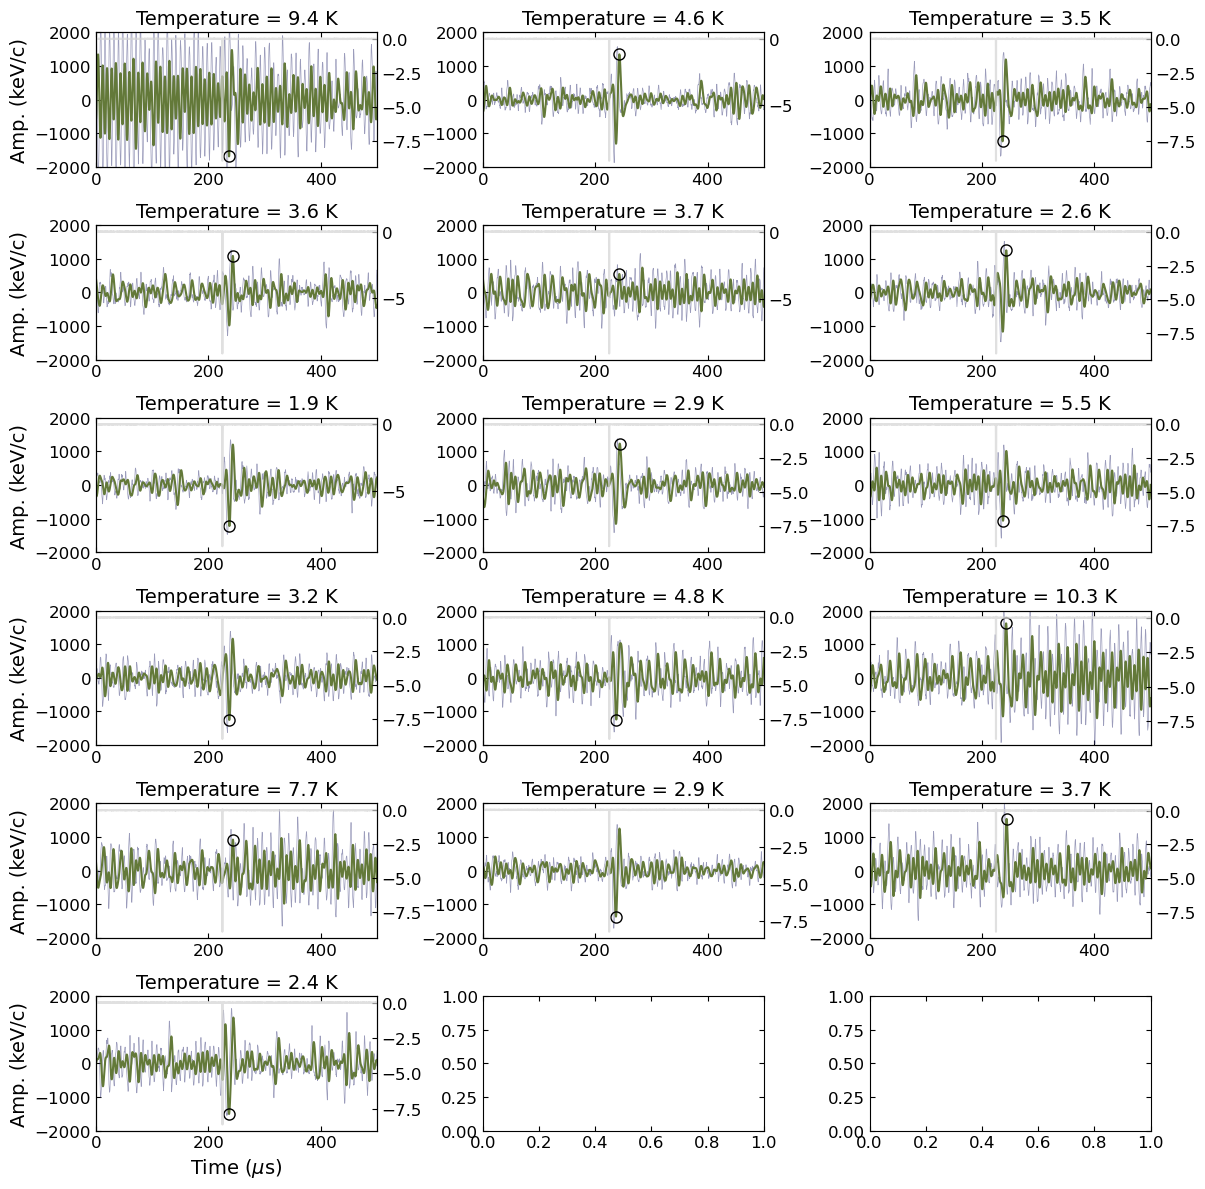

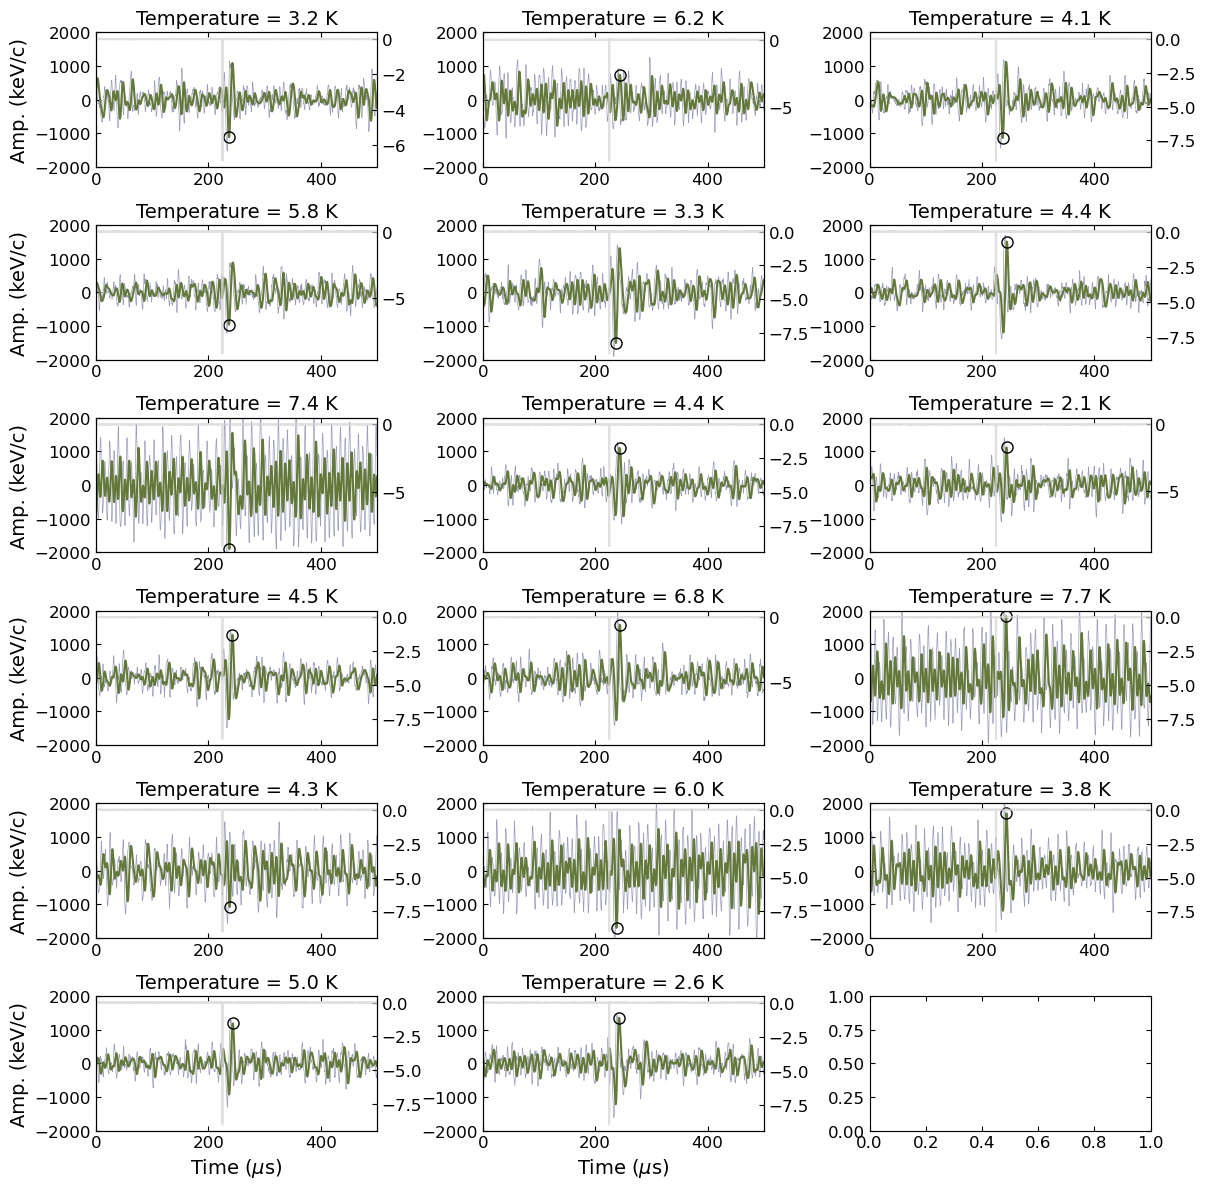

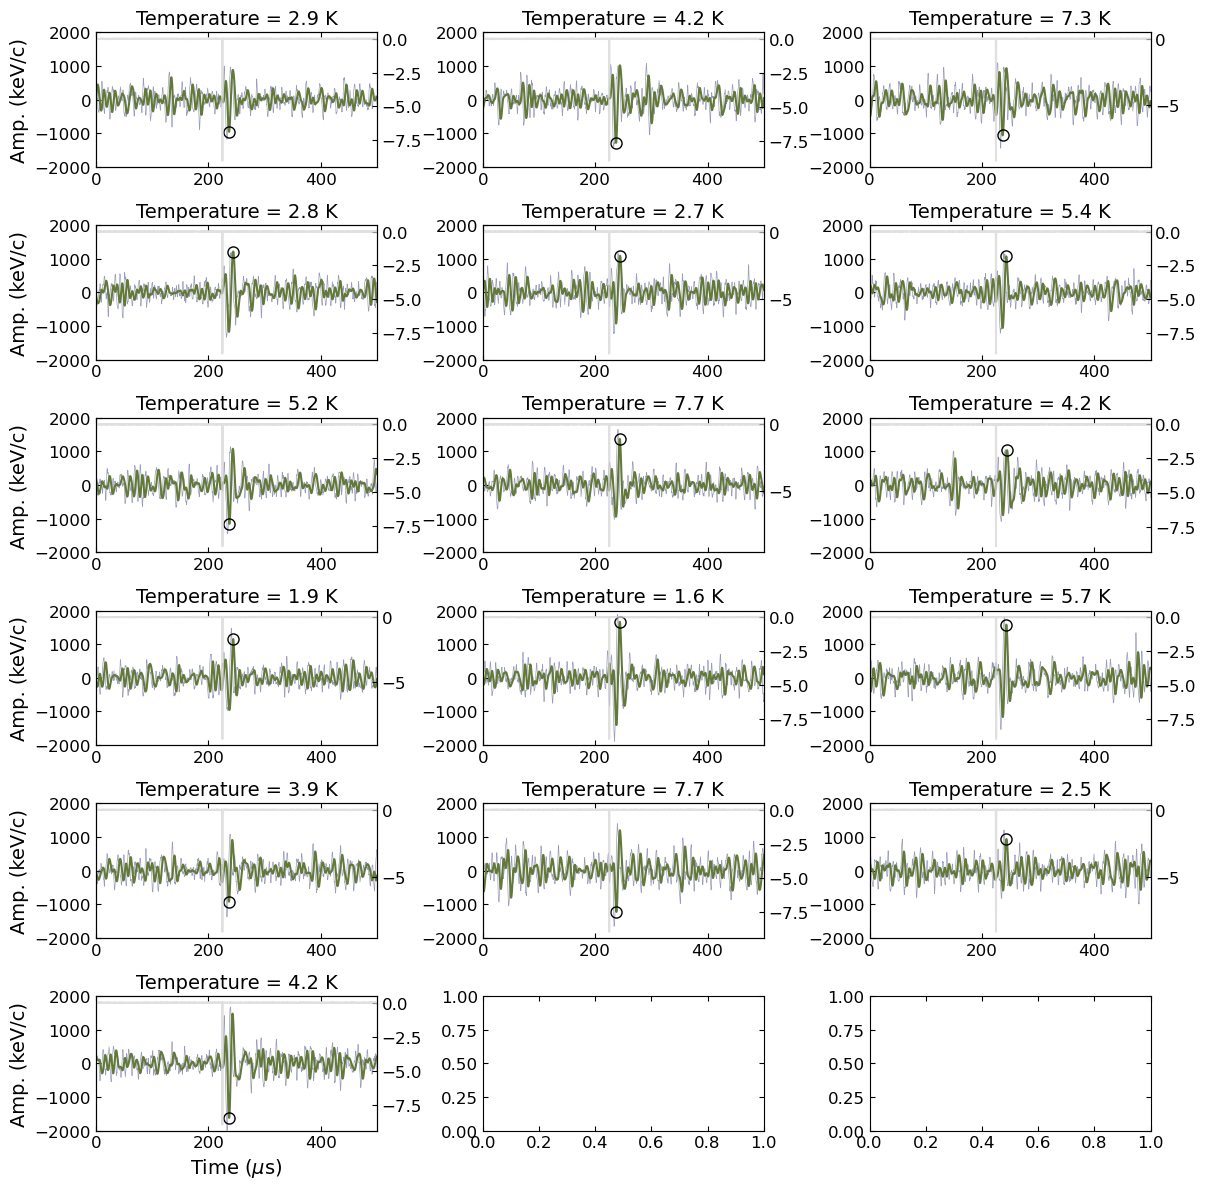

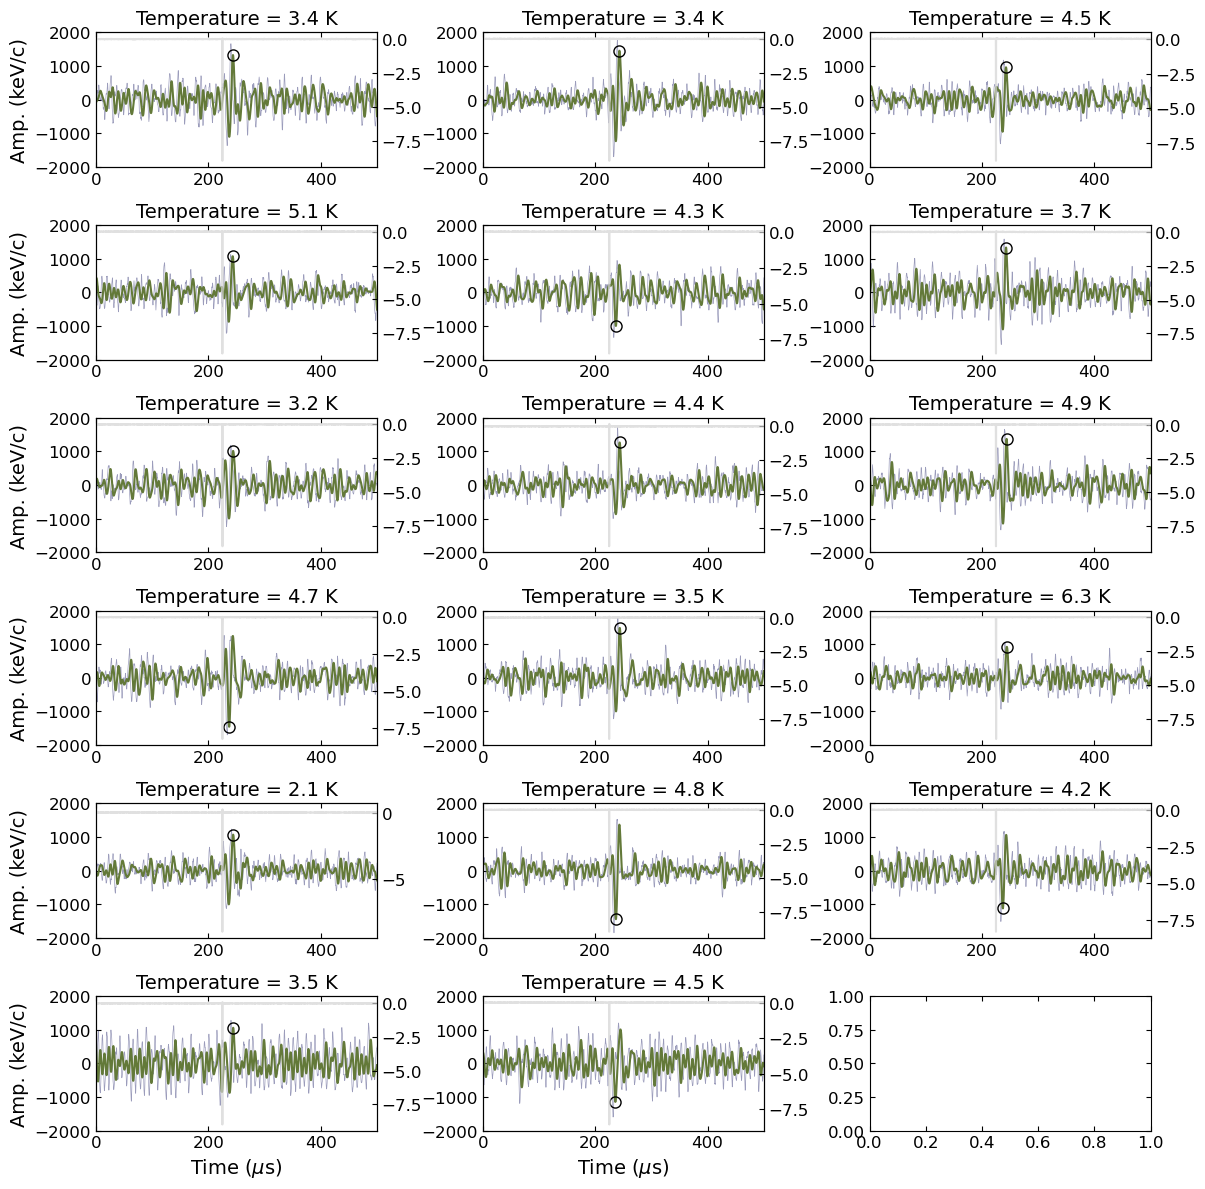

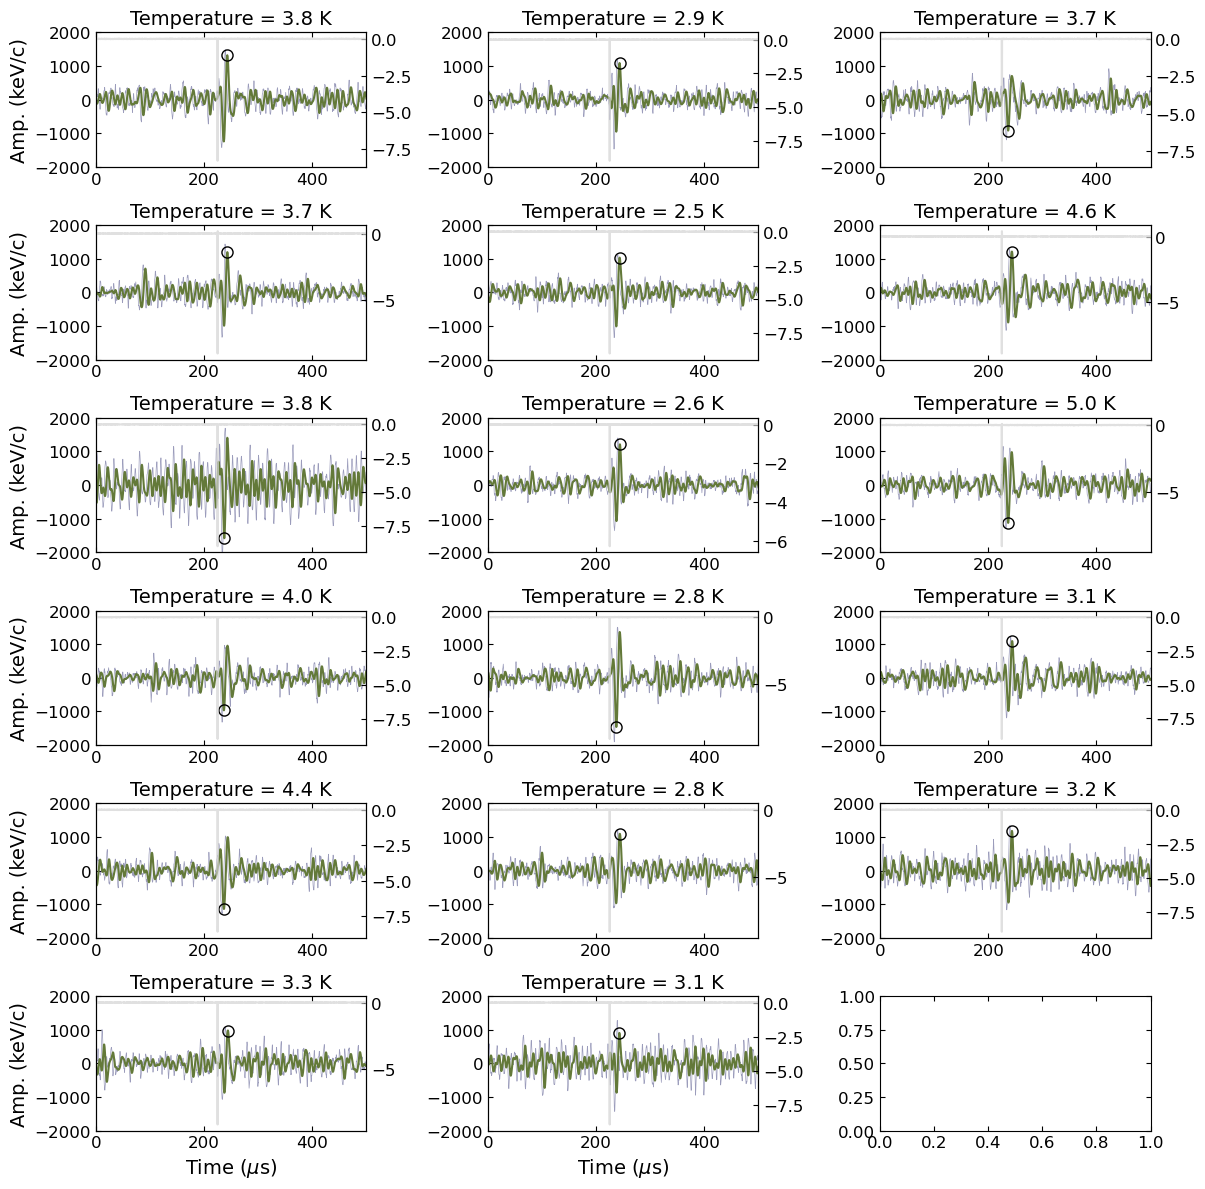

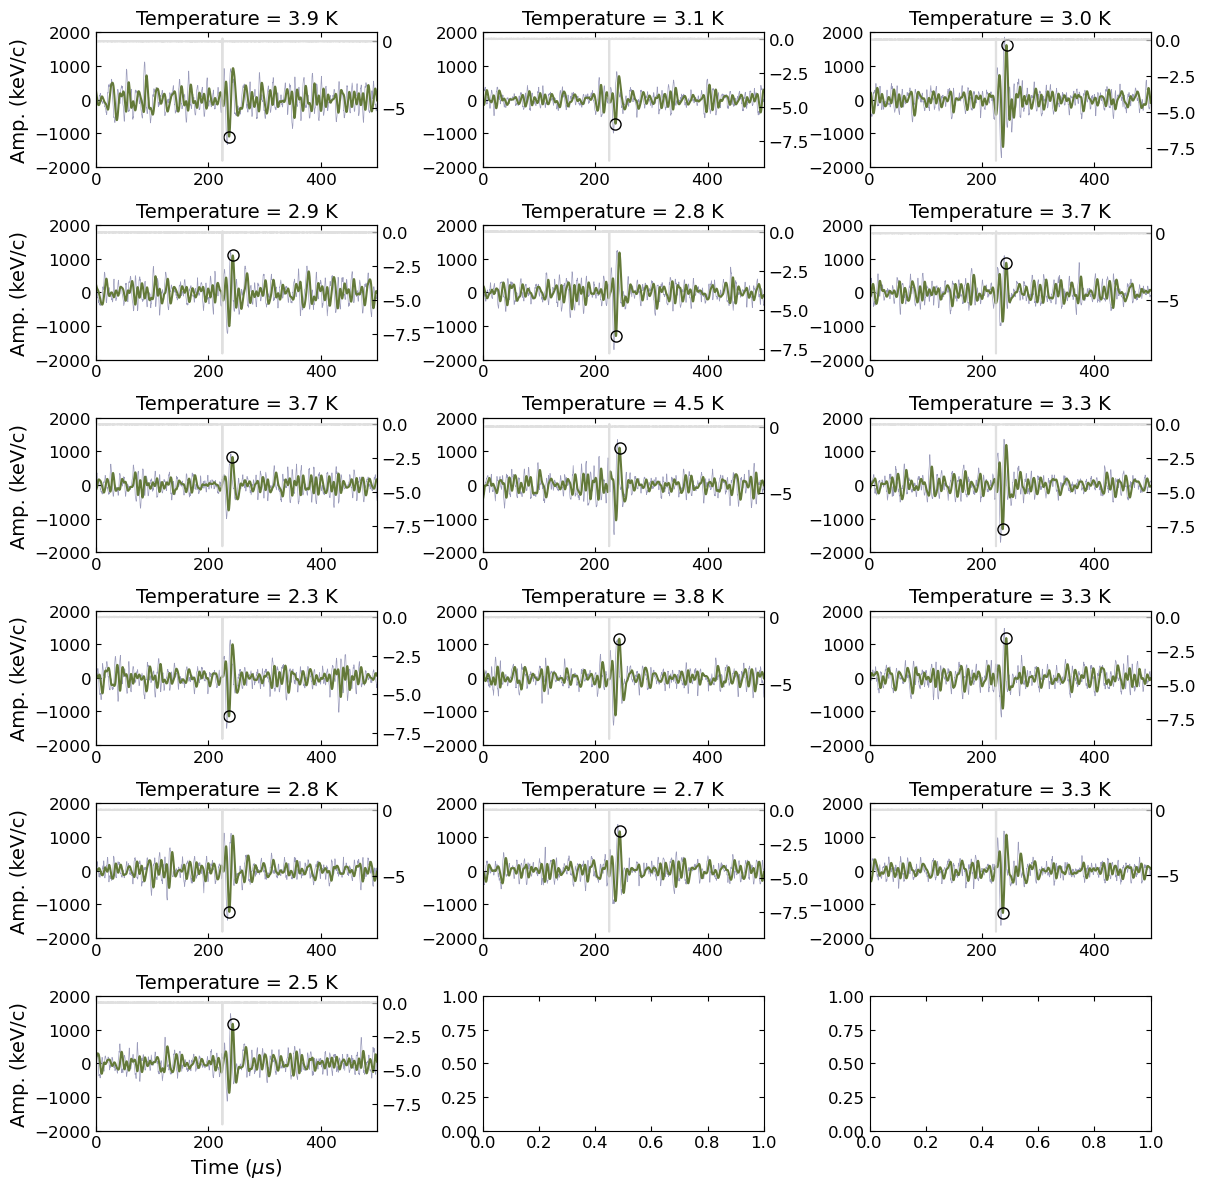

In [478]:
all_amps, all_temps = [], []
for file in data_files:
    dtt, dd, windows, fs, f_lps, pulse_idx, temps, amps = recon_pulses(file)
    plot_recon(dtt, dd, windows, fs, f_lps, pulse_idx, temps)
    
    all_amps.append(amps)
    all_temps.append(temps)

Take a closer look at times when reconstruction is not great. It looks like the sphere is much hotter than normal. This is likely caused by rotation mode coupling to the z motion and heat up the sphere in a random way.

In [347]:
file = data_files[1]
dtt, nn = utils.load_timestreams(file, ['D', 'G'])
tt = np.arange(0, dtt*(nn[0].size), dtt)
fs = int(np.ceil(1 / dtt))

zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 100000)
pulse_idx = utils.get_pulse_idx(dd, -0.5, False)

In [348]:
windows, idx_win = [], []
for i, idx in enumerate(pulse_idx):
    window, pulse_idx_in_window = utils.get_analysis_window(dd, idx, 40000)
    windows.append(window)
    idx_win.append(pulse_idx_in_window)

(30.0, 250.0)

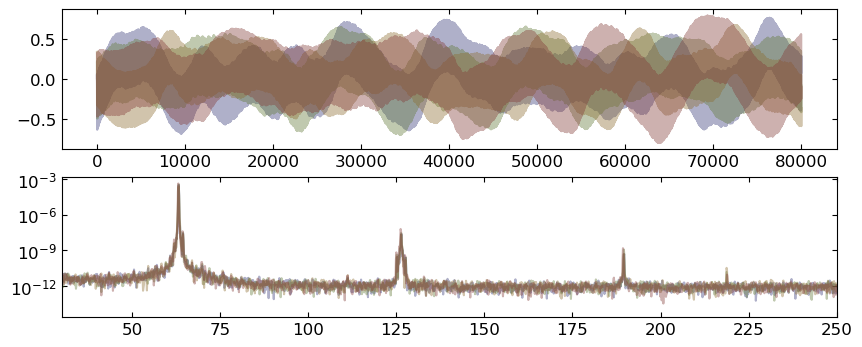

In [426]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4))
for i, window in enumerate(windows[1:5]):
    ffz, ppz = utils.get_psd(dt=dtt, zz=zz[window], nperseg=2**15)
    
    in_band = np.logical_and(ffz>40000, ffz<100000)
    omega0 = ffz[in_band][np.argmax(ppz[in_band])] * 2 * np.pi    
    
    axes[0].plot(zz[window], alpha=0.4)
    axes[1].plot(ffz/1000, ppz, alpha=0.4)
    
axes[1].set_yscale('log')
axes[1].set_xlim(30, 250)

In [495]:
all_temps = np.hstack(all_temps)
q1, q2, q3 = np.quantile(all_temps, [0.25, 0.5, 0.75])

In [496]:
bins = np.linspace(0, np.max(all_temps)*1.2, 50)
hh, be = np.histogram(all_temps, bins=bins)
bc = 0.5 * (be[1:] + be[:-1])

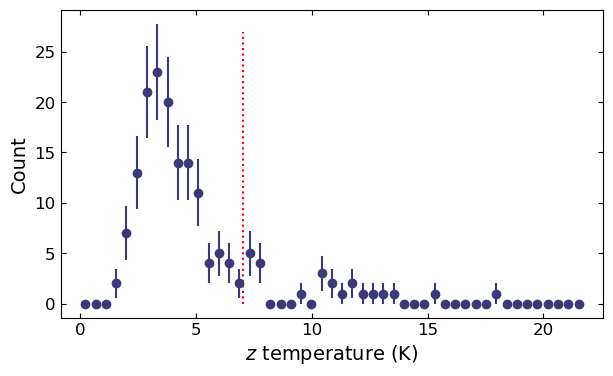

In [505]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o')
ax.set_xlabel('$z$ temperature (K)')
ax.set_ylabel('Count')

temp_threshold = q2 + 1.5*(q3-q1)
# ax.vlines(q2, 0, 10, 'k', linestyle='--', alpha=0.7)
ax.vlines(temp_threshold, 0, 27, 'r', linestyle=':', alpha=1)

Now reject amplitudes that are above the cut threshold and refit for sigma - basically the same as before. However this still reject tail events which would be useful for actual analysis.

In [506]:
all_amps = np.hstack(all_amps)
amps_good = all_amps[all_temps < temp_threshold]

hhs, bcs, gps = utils.fit_amps_gaus([amps_good])
normalized_amps_good = [amp * amp2kev for amp in [amps_good]]

(0.0, 2500.0)

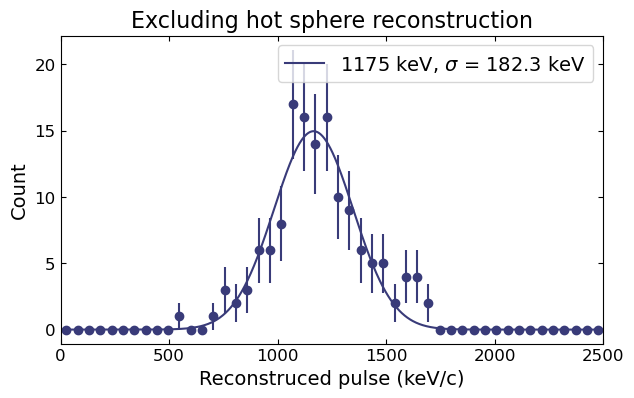

In [554]:
fig, ax = plt.subplots(figsize=(7, 4))
fig, ax = utils.plot_gaus_fit([1175], normalized_amps_good, hhs, bcs, gps, amp2kev=amp2kev, title='Excluding hot sphere reconstruction', fig=fig, ax=ax)
ax.set_xlim(0, 2500)

## Short DM data

In [2]:
from scipy.signal import get_window, ShortTimeFFT

In [3]:
folder = r'/Users/yuhan/work/nanospheres/data/dm_data'
dataset = r'20241008_short_timetrace'
combined_path = os.path.join(folder, dataset, '*.hdf5')
data_files = sorted(glob.glob(combined_path), key=os.path.getmtime)

In [242]:
f = h5py.File(data_files[0], "r")
zz = f['channel_d'][:]
fs = int(np.ceil(1 / f['channel_d'].attrs['delta_t']))

Look into frequency drifting over time. The windowed Fourier transform that we used here is increment 8 ms and has frequency resolution 61 Hz.

In [335]:
window_length = 2**16
w = get_window('boxcar', Nx=window_length)

SFT = ShortTimeFFT(win=w, hop=int(window_length/2), fs=fs, scale_to='psd')

In [54]:
def get_chis_inv(omega, omega0s, gamma):
    chis_inv_transposed = np.empty((omega0s.size, omega.size), dtype=np.complex128)
    for i, omega0 in enumerate(omega0s):
        chis_inv_transposed[i] = (omega0**2 - omega**2 - 1j*gamma*omega)
    
    return chis_inv_transposed.T

def get_force_stft(zz, SFT):
    Szs = SFT.stft(zz)
    
    ff = SFT.f
    omega = SFT.f * 2 * np.pi
    delta_f = SFT.delta_f

    # Get resonant frequency in each time slice
    in_band = np.logical_and(ff>30000, ff<100000)
    ff_in_band = ff[in_band]
    omega0s = np.empty(Szs.shape[-1])

    for i, _sz in enumerate(Szs.T):
        omega0s[i] = ff_in_band[ np.argmax( np.abs(_sz[in_band]) ) ] * 2 * np.pi

    plt.plot(omega0s/(2*np.pi))
    plt.show()
    
    # Get the inverse of transfer function
    chis_inv = get_chis_inv(omega, omega0s, delta_f*2*np.pi)
    Sfs = Szs * chis_inv
    
    return SFT.istft(Sfs)

In [339]:
ff = get_force_stft(zz, SFT)

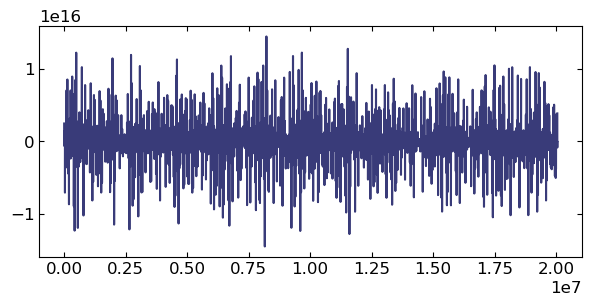

In [340]:
plt.plot(ff)

In [342]:
zz.shape

(20000000,)

In [347]:
ff.size

20054016

In [61]:
f2_file = r'/Users/yuhan/work/nanospheres/data/20241007_10e_data/20241007_9v_4e-8mbar/20241007_9v_4e-8mbar_1.hdf5'
f2 = h5py.File(f2_file, "r")

zz2 = f2['channel_d'][:]/1000
dtt2 = f2['channel_d'].attrs['delta_t']
fs2 = int(np.ceil(1 / f2['channel_d'].attrs['delta_t']))
zzbp2 = utils.bandpass_filtered(zz2, fs2, 40000, 100000)

In [62]:
window_length = 2**15
w = get_window('flattop', Nx=window_length)

SFT = ShortTimeFFT(win=w, hop=int(window_length), fs=fs2, scale_to='psd')

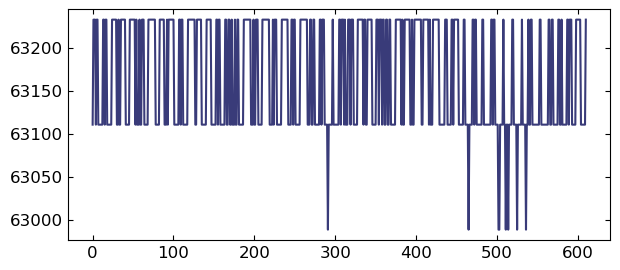

In [63]:
ff2 = get_force_stft(zzbp2, SFT)
ff2_lp = utils.bandpass_filtered(ff2, fs2, 40000, 100000, 3)

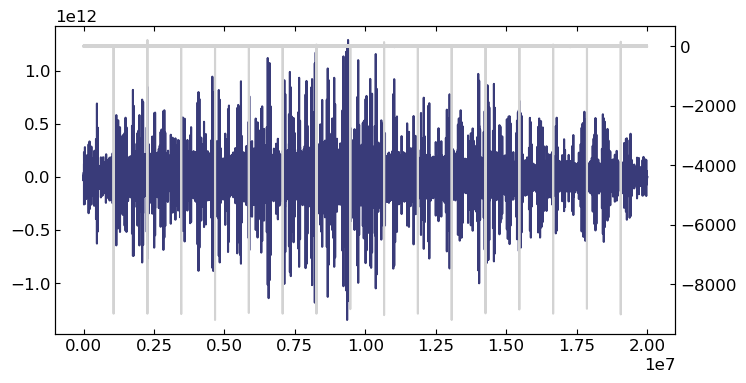

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(ff2_lp)
ax.twinx().plot(f2['channel_g'][:], color='lightgrey')

# ax.set_ylim(-0.5e13, 0.5e13)

In [344]:
SFT.m_num

65536

In [69]:
from scipy.fft import rfft, irfft, rfftfreq

omega0 = 63100 * 2 * np.pi
gamma = 10 * 2 * np.pi

zz_bp = zzbp2

zzk = rfft(zz_bp)
ff = rfftfreq(zz_bp.size, dtt2)
omega = ff * 2 * np.pi

ffk = zzk * (omega0**2 - omega**2 - 1j*gamma*omega)

ff = irfft(ffk)
ff_lp = utils.lowpass_filtered(ff, fs2, 100000, 3)

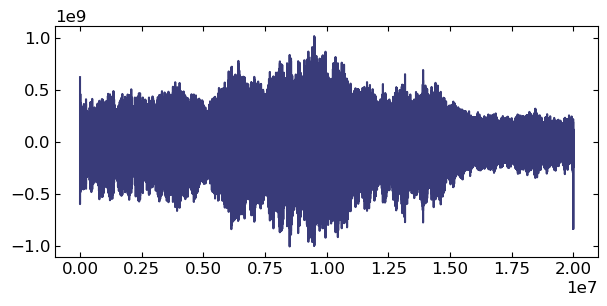

In [70]:
plt.plot(ff_lp[200:])

In [336]:
Szs.shape


(32769, 612)

Text(0, 0.5, 'Fitted frequency (Hz)')

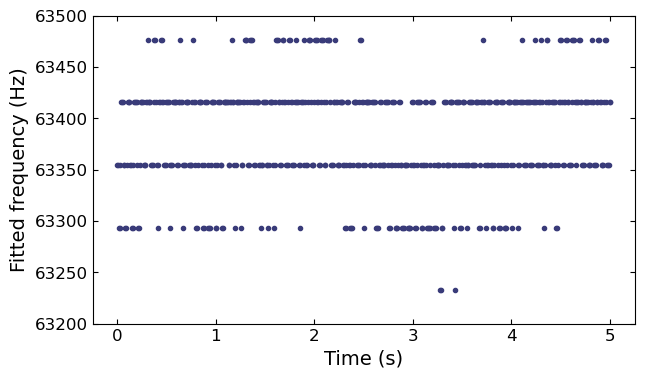

In [321]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(tt, omega0s/(2*np.pi), '.')
ax.set_ylim(63200, 63500)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fitted frequency (Hz)')

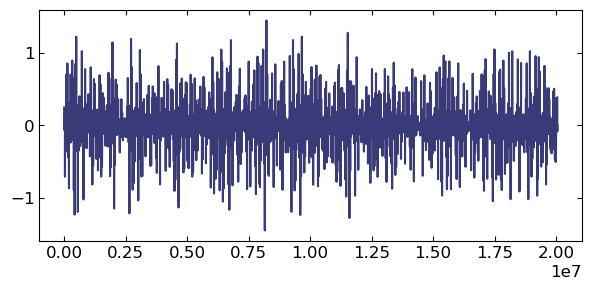

In [333]:
plt.plot(ff/1e16)

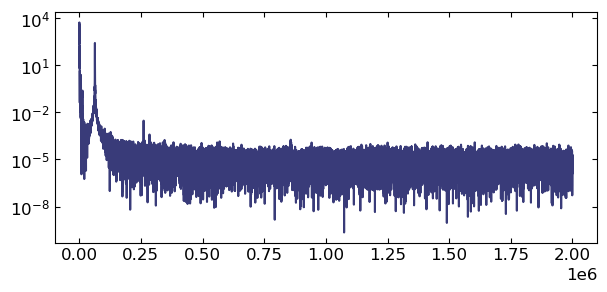

In [265]:
plt.plot(ff, np.abs(zxx.T[0])**2)
plt.yscale('log')

In [263]:
tt.shape

(612,)